### Group No: 09
### Group Members: 
#### 1) Devashish Mahajan (007)
#### 2) Imroze Khan (029)
#### 3) Manvi Poddar (024)
#### 4) Soham Rangdal (044)

### Topic: Brain tumor classification from magnetic resonace images with ennsemble convolution neural network model and feature selection architecture

#### Versions of libraries in training enviroment

Tensorflow = 2.9.1

numpy = 1.23.0

pandas = 1.4.3

matplotlib = 3.5.2

matplotlib-inline = 0.1.2

keras = 2.9.0

keras-preprocessing = 1.1.2

sklearnn = 1.1.1

In [1]:
### Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

In [2]:
#Check for GPU available
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
%matplotlib inline

Num GPUs Available:  1


In [3]:
# Some basic parameters

inpDir = 'brain-tumor-mri-dataset' # location where input data is stored
outDir = 'brain-tumor-mri-dataset' # location to store outputs
subDir = 'Training'

modelDir = 'Models'
valDir = 'Testing'
altName = 'Brain_tumor_classification_Model_Checkpoints'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)

EPOCHS = 100 # number of cycles to run

#BATCH_SIZE = 8 # increse in batch size cause resource exhausted
BATCH_SIZE = 16
#BATCH_SIZE = 64
#BATCH_SIZE = 32


ALPHA = 0.001

TEST_SIZE = 0.2

IMG_HEIGHT = 224

IMG_WIDTH = 224

# MRI image shape
SHAPE = (IMG_HEIGHT,IMG_WIDTH, 3)


#SGDRScheduler parameters
ES_PATIENCE = 50 # if performance does not improve stop

LR_PATIENCE = 5 # if performace is not improving reduce alpha

LR_FACTOR = 0.9 # rate of reduction of alpha



# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [4]:
#Function to plot histogram of accuarcy and loss during training
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [5]:
#Function to plot count of individual labels to check balance of dataset
def fn_plot_label(tr_ds, ts_ds):
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)

    train_labels = tf.concat([y for x, y in tr_ds], axis = 0).numpy()
    
    unique, _, counts = tf.unique_with_counts(train_labels)
    
    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.7)
    
    plt.title('Training Set')
    
    plt.xticks(range(len(unique)), class_names);
    plt.grid()


    plt.subplot(1,2,2)

    val_labels = tf.concat([y for x, y in ts_ds], axis = 0).numpy()
    
    unique, _, counts = tf.unique_with_counts(val_labels)
    
    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.7)
    
    plt.title('Test Set')
    
    plt.xticks(range(len(unique)), class_names)
    
    plt.grid()
    
    plt.show()

## Load Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!rm -r ~/.kaggle
! mkdir ~/.kaggle

In [9]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [10]:
!echo '{"username":"donotirritate","key":"fb7bb2b4b64fae370314c5b6fa6a68bf"}' > ~/.kaggle/kaggle.json

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle config path -p /content

usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')


In [13]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip brain-tumor-mri-dataset

In [15]:
!gdown --fuzzy https://drive.google.com/file/d/1XTHmc46i4AkNPfKgv3AXgyZn9bQH2qmG/view?usp=sharingJzePjYGT2lI61mB3jSc

Downloading...
From: https://drive.google.com/uc?id=1XTHmc46i4AkNPfKgv3AXgyZn9bQH2qmG
To: /content/brain-tumor-mri-dataset.zip
100% 156M/156M [00:00<00:00, 265MB/s]


In [ ]:
!rm -r brain-tumor-mri-dataset
!mkdir brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset

In [17]:
inpDir = 'brain-tumor-mri-dataset' # location where input data is stored
data_dir = os.path.join(inpDir, subDir)
data_dir

'brain-tumor-mri-dataset/Training'

In [18]:
# load data and split in training and validation from a sub dir

# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = TEST_SIZE,
    subset = "training",
    seed = RANDOM_STATE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE)

# testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = TEST_SIZE,
    subset = "validation",
    seed = RANDOM_STATE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [19]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [20]:
train_ds.sample_from_datasets
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

# Is it picking the class names?

In [21]:
class_names = train_ds.class_names
print('Total: {:3d} Classes; namely : {:s}'.format(len(class_names), str(class_names)))

Total:   4 Classes; namely : ['glioma', 'meningioma', 'notumor', 'pituitary']


# Verify the data
To verify that the dataset looks correct, let's plot a batch from the training set and display the class name below each image.

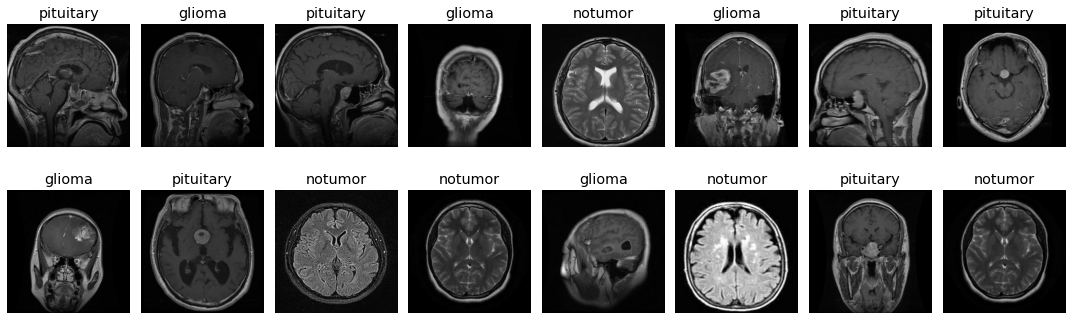

In [22]:
plt.figure(figsize=(15,5))

for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(2,int(BATCH_SIZE/2),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float
        
        plt.title(class_names[labels[i]])
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

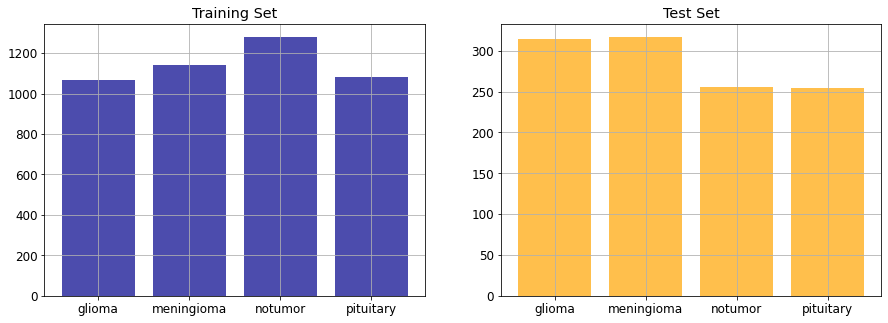

In [23]:
#Function to plot count of individual labels to check balance of dataset
fn_plot_label(train_ds, test_ds)

# Input shape
If we plan to use input layer, we need input shape. Alternatively, we use .build() on the model and let framework capture input shape from the data

In [24]:
images[i].shape

TensorShape([224, 224, 3])

In [25]:
#It is prefered to not normalize data when doing augmentation

"""
normalization_layer = tf.keras.layers.Rescaling(1./255.)

img_batch, l_batch = next(iter(train_ds))

img = img_batch[0]

print (np.max(img), np.min(img))

train_ds = train_ds.map(lambda X, y: (normalization_layer(X), y) )
test_ds = test_ds.map(lambda X, y: (normalization_layer(X), y) )

img_batch, l_batch = next(iter(train_ds))

img = img_batch[0]
print (np.max(img), np.min(img))
"""

'\nnormalization_layer = tf.keras.layers.Rescaling(1./255.)\n\nimg_batch, l_batch = next(iter(train_ds))\n\nimg = img_batch[0]\n\nprint (np.max(img), np.min(img))\n\ntrain_ds = train_ds.map(lambda X, y: (normalization_layer(X), y) )\ntest_ds = test_ds.map(lambda X, y: (normalization_layer(X), y) )\n\nimg_batch, l_batch = next(iter(train_ds))\n\nimg = img_batch[0]\nprint (np.max(img), np.min(img))\n'

In [26]:
## Optimize for performance
#loading data into cache for faster execution
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Preparation

In [27]:
#Libraries for model building

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import load_model, Model

import tensorflow as tf
from keras import backend as K

In [28]:
SHAPE = (224, 224, 3) #input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)

#BATCH_SIZE = 8
BATCH_SIZE = 16
#BATCH_SIZE = 32
#BATCH_SIZE = 64


### cbam_block, channel_attention, spatial_attention

In [29]:

def cbam_block(cbam_feature, ratio=8):
        
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

## residual_block

In [30]:

def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [31]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip( mode="horizontal_and_vertical", input_shape=(IMG_HEIGHT, IMG_WIDTH,3)), 
    tf.keras.layers.RandomRotation((-0.2,0.2)), #Rotate Limit=20°
    tf.keras.layers.RandomZoom(0.1,0.1)
  ]
)


## Create model

In [32]:
def create_model():
    
    dropRate = 0.3
    
    #STAGE 1
    #Input layer
    init = Input(SHAPE)
    x = data_augmentation(init)

    #Convolution layer 1.1
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #Convolution layer 1.2
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #Max pooling layer 1.1
    x1 = MaxPooling2D((2,2))(x)
    

    #STAGE 2
    #Convolution layer 2.1
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #CBAM Block
    x = cbam_block(x)

    #Residual Block
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    #STAGE 3
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #CBAM Block
    x = cbam_block(x)

    #Residual Block
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    #Hypercolumn
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 

    # Global Average Pooling
    gap = GlobalAveragePooling2D()(hypercolumn)


    #Dense layer 1
    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #Dropout layer
    x = Dropout(dropRate)(x)
    
    #Dense layer 2
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output Dense layer# Output Dense layer
    y = Dense(4, activation='softmax')(x)
   
    model = Model(init, y)
    return model

In [33]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['sequential[0][0]']             
                                )                                                                 
                                                                                              

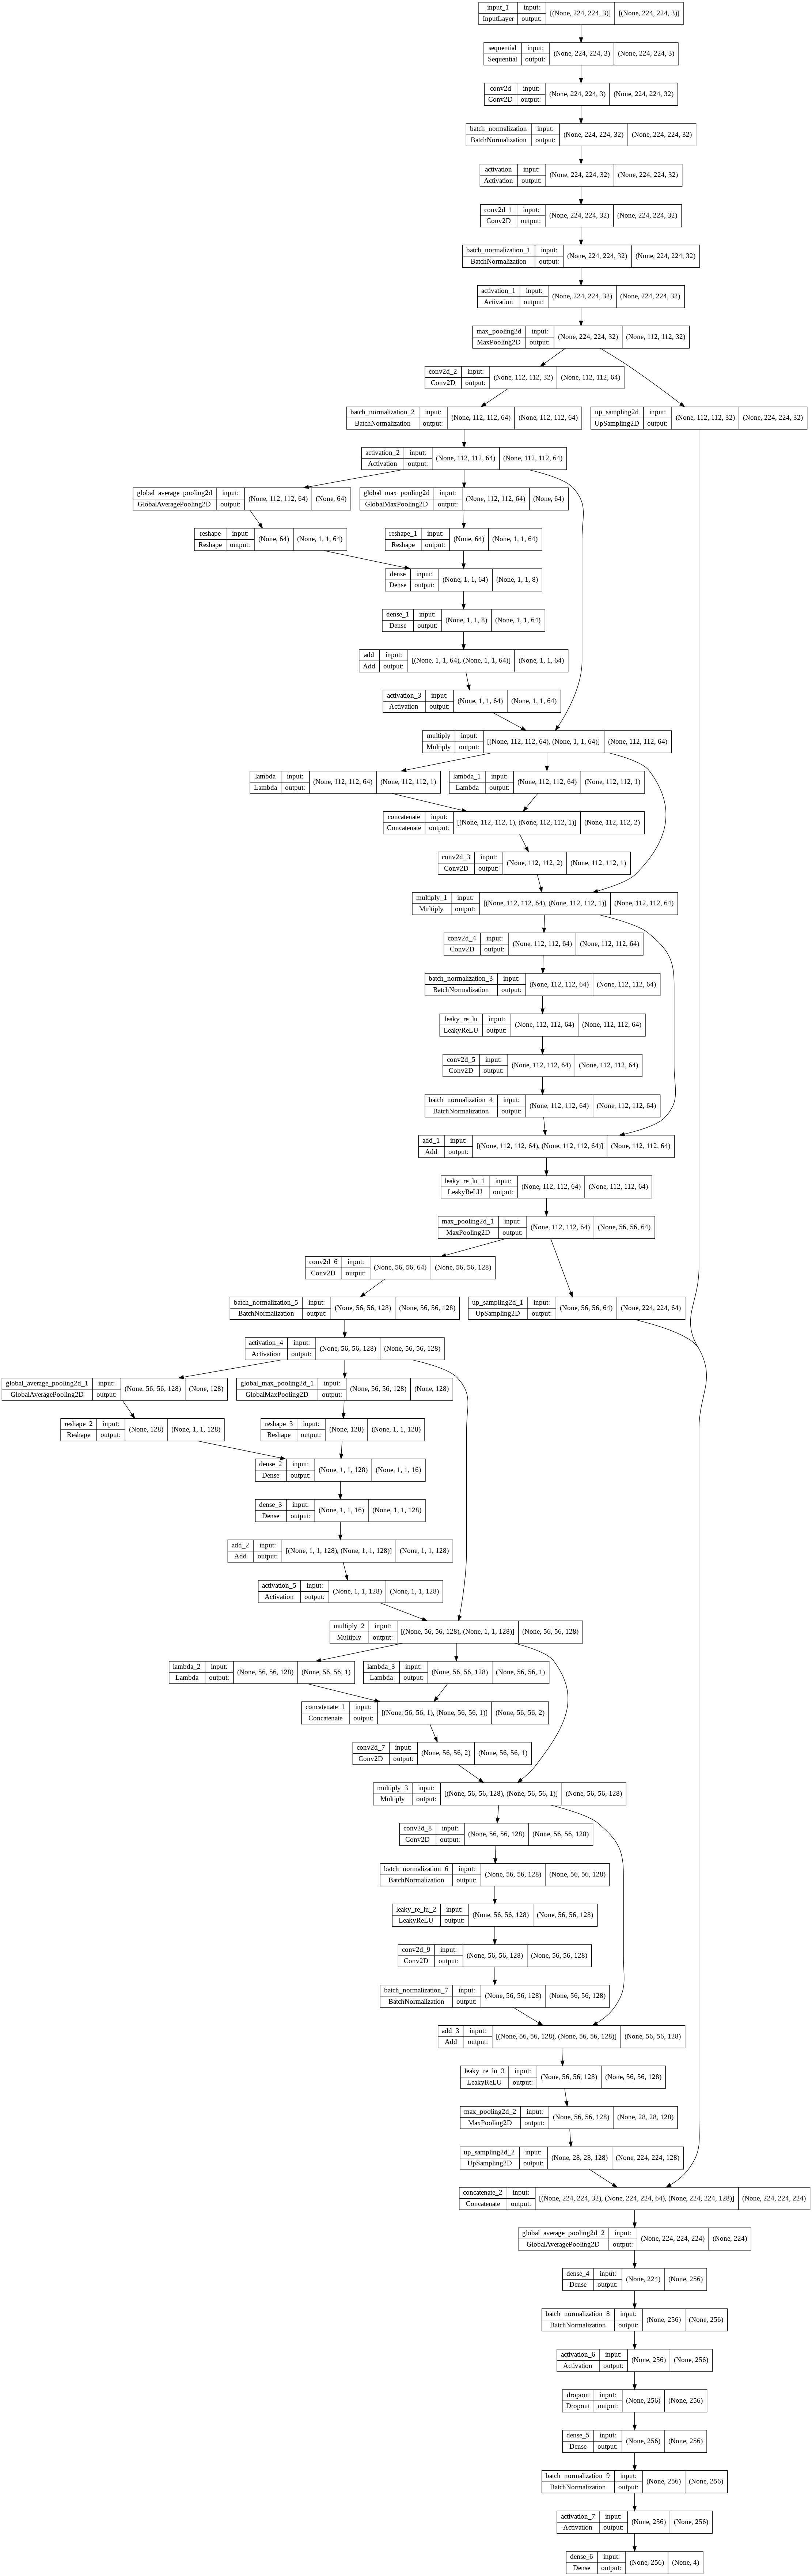

In [34]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

In [36]:

# Directory where the checkpoints will be saved
checkpoint_dir = os.path.join(modelDir, subDir)
print("checkpoint_dir ", checkpoint_dir)

# Early Stopping
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)


# Reduction schedukle for alpha
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=LR_FACTOR,
                                                 patience=LR_PATIENCE)


checkpoint_prefix = os.path.join(checkpoint_dir, altName)
print("checkpoint_prefix ",checkpoint_prefix)

# Save weights
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])



checkpoint_dir  Models/Training
checkpoint_prefix  Models/Training/Brain_tumor_classification_Model_Checkpoints


In [37]:
# Train Model
history = model.fit(train_ds,
                    validation_data=test_ds,
                    callbacks=[ early_callback, model_callback, lr_reduce],
                    epochs=EPOCHS)

Epoch 1/100
286/286 [==============================] - ETA: 0s - loss: 0.8703 - accuracy: 0.6545
Epoch 1: val_loss improved from inf to 4.18590, saving model to Models/Training/Brain_tumor_classification_Model_Checkpoints
286/286 [==============================] - 73s 200ms/step - loss: 0.8703 - accuracy: 0.6545 - val_loss: 4.1859 - val_accuracy: 0.2986 - lr: 0.0010
Epoch 2/100
286/286 [==============================] - ETA: 0s - loss: 0.7206 - accuracy: 0.7140
Epoch 2: val_loss improved from 4.18590 to 2.76461, saving model to Models/Training/Brain_tumor_classification_Model_Checkpoints
286/286 [==============================] - 55s 191ms/step - loss: 0.7206 - accuracy: 0.7140 - val_loss: 2.7646 - val_accuracy: 0.3275 - lr: 0.0010
Epoch 3/100
286/286 [==============================] - ETA: 0s - loss: 0.6362 - accuracy: 0.7490
Epoch 3: val_loss improved from 2.76461 to 1.45603, saving model to Models/Training/Brain_tumor_classification_Model_Checkpoints
286/286 [=======================

In [38]:
#Convert history to pandas dataframe
res_df = pd.DataFrame(history.history)
res_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.870325,0.654486,4.185902,0.298599,0.001000
1,0.720557,0.714004,2.764609,0.327496,0.001000
2,0.636172,0.749015,1.456028,0.528021,0.001000
3,0.582637,0.778775,0.823924,0.675131,0.001000
4,0.540567,0.790810,1.834434,0.462347,0.001000
...,...,...,...,...,...
72,0.039069,0.986652,0.213828,0.940455,0.000282
73,0.033774,0.988621,0.635801,0.846760,0.000282
74,0.032036,0.988840,0.312787,0.907180,0.000282
75,0.030724,0.989934,0.248474,0.923818,0.000282


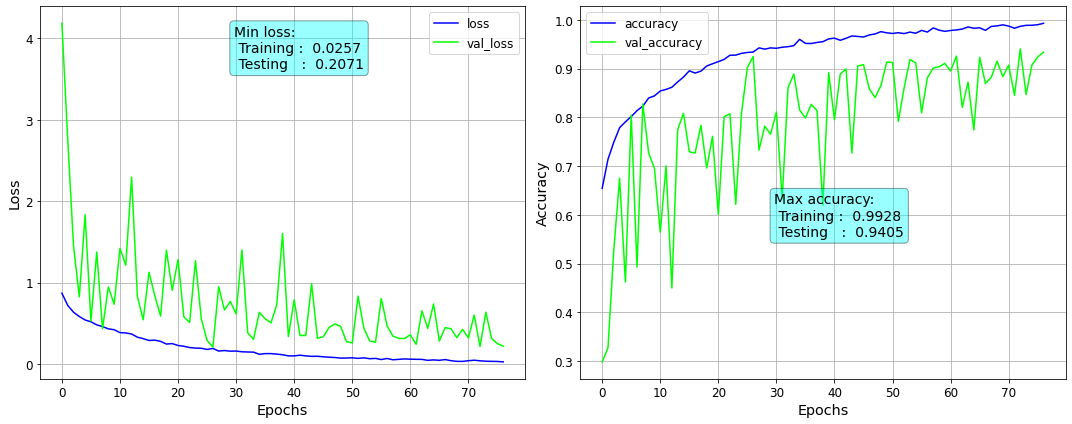

In [39]:
# Helper Function
# Plot loss and accuracy curves for both testing and training
fn_plot_hist(res_df) #ALPHA = 0.001  #BATCH_SIZE = 16  #with  data augmentation

In [50]:
#model.load_weights('/content/Models/Training/Brain_tumor_classification_Model_Checkpoints.data-00000-of-00001')
model.save('Brain_tumor_classification_Model.h5')
model = load_model('Brain_tumor_classification_Model.h5')

# Evaluate the model

In [51]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

72/72 [==============================] - 5s 56ms/step - loss: 0.2071 - accuracy: 0.9247


In [52]:
yhat = model.predict(test_ds)

In [53]:
y_test = np.concatenate([y for X, y in test_ds], axis=0).squeeze()

In [54]:
y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score on Test Data : 0.9247


# Classification_report

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       254
           1       0.90      0.85      0.87       256
           2       0.97      0.92      0.94       315
           3       0.90      0.98      0.94       317

    accuracy                           0.92      1142
   macro avg       0.92      0.92      0.92      1142
weighted avg       0.93      0.92      0.92      1142



# Confusion matrix

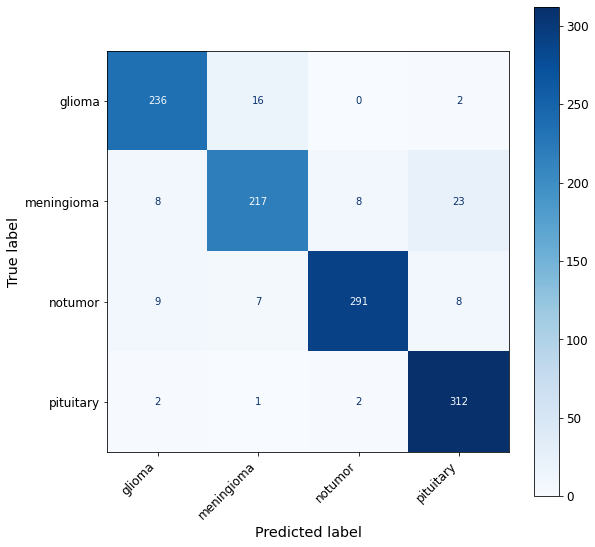

In [56]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_names)

fig, ax = plt.subplots(figsize = (9,9))
disp.plot(ax = ax, cmap=plt.cm.Blues);
ax.set_xticklabels(class_names,rotation=45, ha='right');

# Running on Validation Dataset

In [57]:
val_dir = os.path.join(inpDir, valDir)
print("val_dir ", val_dir)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, 
                                                     validation_split=None, 
                                                     seed=RANDOM_STATE,
                                                     image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=BATCH_SIZE)

val_dir  brain-tumor-mri-dataset/Testing
Found 1311 files belonging to 4 classes.


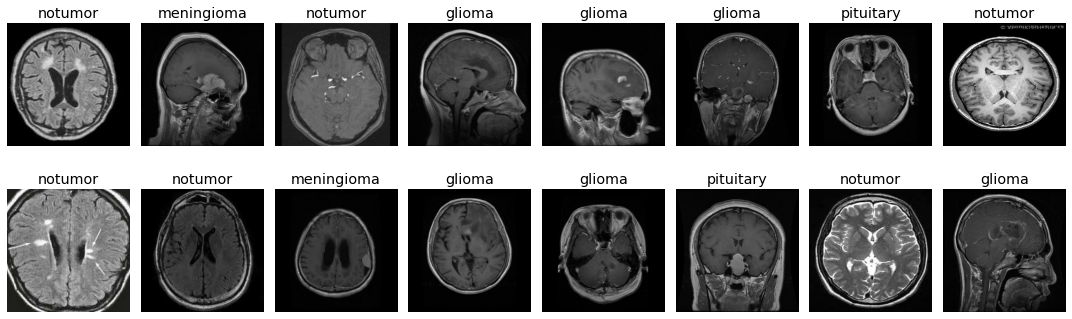

In [58]:
plt.figure(figsize=(15,5))

for images, labels in val_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(int(BATCH_SIZE/8), 8, i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float
        
        plt.title(class_names[labels[i]])
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

In [ ]:
#val_ds = val_ds.map(lambda X, y: (normalization_layer(X), y) )

In [59]:
## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [79]:
test_loss, test_acc = model.evaluate(val_ds, verbose=1)

82/82 [==============================] - 5s 58ms/step - loss: 0.2812 - accuracy: 0.8970


In [80]:
yhat = model.predict(val_ds)

y_pred = yhat.argmax(axis = 1)

y_test = np.concatenate([y for x, y in val_ds], axis=0).squeeze()

print('Accuracy score on Test Data :{:.4f}'.format(accuracy_score(y_test, y_pred)) )

Accuracy score on Test Data :0.8970


# Predict on single image

In [85]:
!ls

Brain_tumor_classification_Model2.h5  drive	   Testing
Brain_tumor_classification_Model.h5   model.png    Training
brain-tumor-mri-dataset		      Models	   Tr-no_0014.jpg
brain-tumor-mri-dataset.zip	      sample_data


In [94]:
!cd brain-tumor-mri-dataset/
!mkdir brain-tumor-mri-dataset/test
!mkdir brain-tumor-mri-dataset/test/Test_Image

mkdir: cannot create directory ‘brain-tumor-mri-dataset/test/Test_Image’: File exists


In [87]:
!ls

Brain_tumor_classification_Model2.h5  drive	   Testing
Brain_tumor_classification_Model.h5   model.png    Training
brain-tumor-mri-dataset		      Models	   Tr-no_0014.jpg
brain-tumor-mri-dataset.zip	      sample_data


In [105]:
Test_Image_dir = 'test'
Test_Image_dir = os.path.join(inpDir, Test_Image_dir)
print(Test_Image_dir)

brain-tumor-mri-dataset/test


In [103]:
!gdown --fuzzy https://drive.google.com/file/d/1flLPwdTlpFymWej3TQ-53ox8_X_C2scL/view?usp='/content/brain-tumor-mri-dataset/test/Test_Image'
# !unzip <"test_image_dataset"> -d brain-tumor-mri-dataset/Test_Image

Downloading...
From: https://drive.google.com/uc?id=1flLPwdTlpFymWej3TQ-53ox8_X_C2scL
To: /content/Tr-no_0014.jpg
100% 58.8k/58.8k [00:00<00:00, 68.5MB/s]


In [106]:
test_image_ds = tf.keras.utils.image_dataset_from_directory(Test_Image_dir, image_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1 files belonging to 1 classes.


In [ ]:
# Prefered to not normalize data when doing augmentation
"""
test_image_ds = test_image_ds.map(lambda X, y: (normalization_layer(X), y) )
"""

In [107]:
yhat = new_model.predict(test_image_ds)
yhat

array([[0.36474687, 0.00076904, 0.63200814, 0.00247597]], dtype=float32)

In [108]:
y_pred = yhat.argmax(axis = 1)
y_pred[0]

2

In [109]:
class_names[y_pred[0]]

'notumor'

In [110]:
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']